# Identifying outliers in the US Education data 

Import relevant libraries.

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import warnings

warnings.filterwarnings('ignore')

Connect to the database and query the `useducation` table.

In [44]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'useducation'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

# education_df = pd.read_sql_query('select * from youtube',con=engine)
with engine.begin() as conn:
    query = text("""SELECT * FROM useducation""")
    education_df = pd.read_sql_query(query, conn)

# No need for an open connection,
# because you're only doing a single query
engine.dispose()

As our data is time series data, we can interpolate the missing values.

In [45]:
# Make a new list of columns to deal with the null values
cols_with_nulls = ["ENROLL", "TOTAL_REVENUE", "FEDERAL_REVENUE",
             "STATE_REVENUE", "LOCAL_REVENUE", "TOTAL_EXPENDITURE",
             "INSTRUCTION_EXPENDITURE", "SUPPORT_SERVICES_EXPENDITURE",
             "OTHER_EXPENDITURE", "CAPITAL_OUTLAY_EXPENDITURE", "GRADES_PK_G",
             "GRADES_KG_G", "GRADES_4_G", "GRADES_8_G", "GRADES_12_G", "GRADES_1_8_G",
             "GRADES_9_12_G", "GRADES_ALL_G", "AVG_MATH_4_SCORE", "AVG_MATH_8_SCORE",
             "AVG_READING_4_SCORE", "AVG_READING_8_SCORE"]

states = education_df["STATE"].unique()

# Interpolate the time series data
for state in states:
    education_df.loc[education_df["STATE"] == state, cols_with_nulls] = education_df.loc[education_df["STATE"] == state, cols_with_nulls].interpolate()

# Drop the null values after interpolation
education_df.dropna(inplace=True)

#### Q1. Consider the two variables `TOTAL_REVENUE` and `TOTAL_EXPENDITURE`. Do these variables have outlier values?

To see if these two variables have outliers, we can make a boxplot.

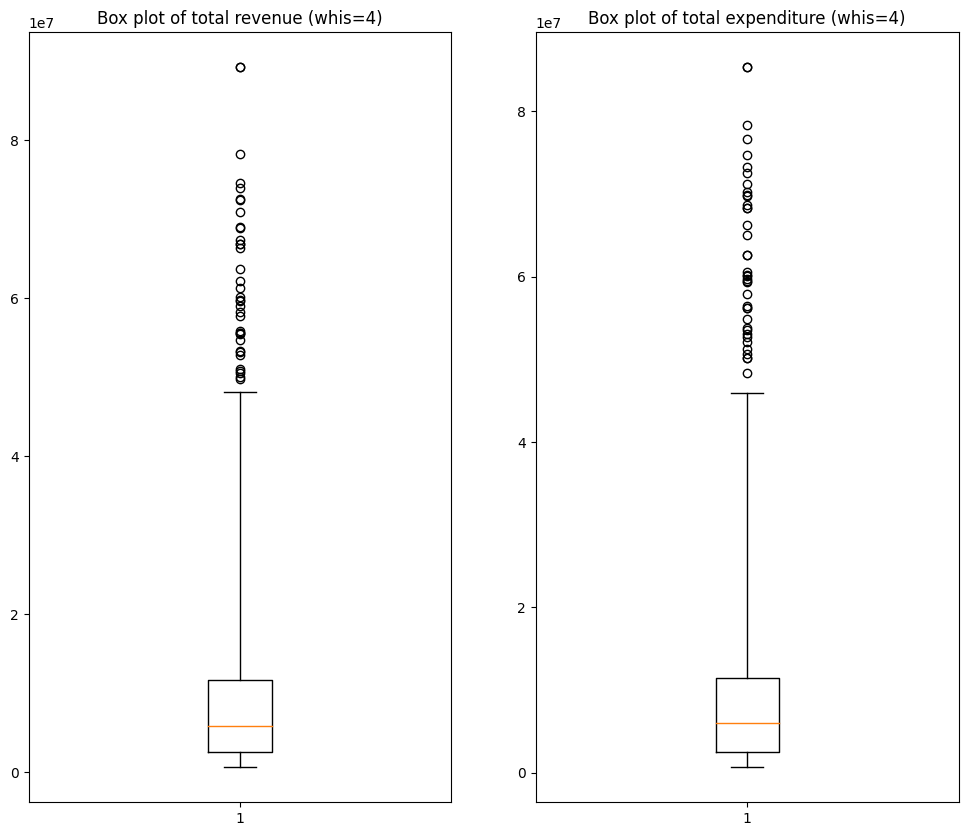

In [46]:
plt.figure(figsize = (12,10))

plt.subplot(1,2,1)
plt.boxplot(education_df["TOTAL_REVENUE"], whis = 4)
plt.title("Box plot of total revenue (whis=4)")

plt.subplot(1,2,2)
plt.boxplot(education_df["TOTAL_EXPENDITURE"], whis = 4)
plt.title("Box plot of total expenditure (whis=4)")
plt.show()

Both variables shave outliers.

#### Q2: If you detect outliers in the `TOTAL_REVENUE` and `TOTAL_EXPENDITURE` variables, apply the techniques you learned in this lesson to eliminate them and validate that there are no outlier values after you handle them.

As suggested in the lesson, we will cap the value of the outliers through winsorization. We will set limits on the lowest end and the highest end of the value distribution.

In [47]:
from scipy.stats.mstats import winsorize

# Apply one-way winsorization to the highest end
# of the value distribution. Because we have a lot of extreme
# values, set the values of the outliers to the
# value of the ninetieth percentile.
winsorized_revenue = winsorize(education_df["TOTAL_REVENUE"], (0, 0.10))
winsorized_expenditure = winsorize(education_df["TOTAL_EXPENDITURE"], (0, 0.10))

We will now check if this eliminates the outliers.

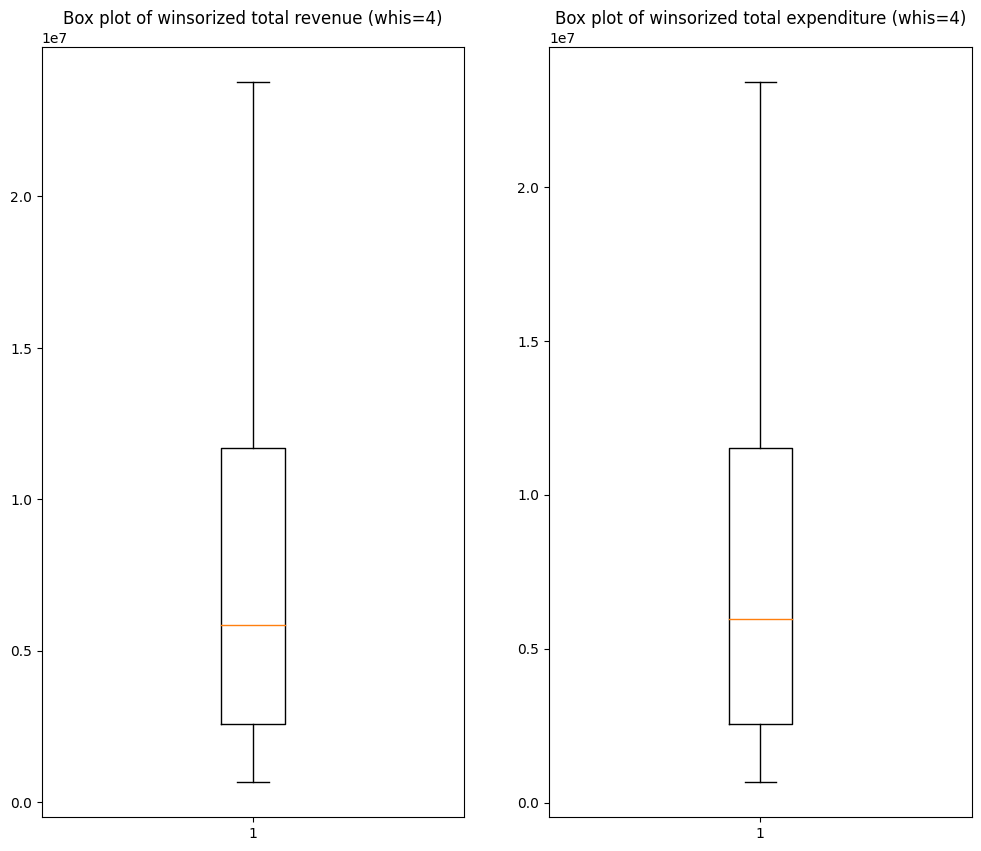

In [48]:
plt.figure(figsize = (12,10))

plt.subplot(1,2,1)
plt.boxplot(winsorized_revenue, whis = 4)
plt.title("Box plot of winsorized total revenue (whis=4)")

plt.subplot(1,2,2)
plt.boxplot(winsorized_expenditure, whis = 4)
plt.title("Box plot of winsorized total expenditure (whis=4)")
plt.show()

The outliers are now visually removed after winsorization.

#### Q3 .Create another variable by subtracting the original `TOTAL_EXPENDITURE` from `TOTAL_REVENUE` (before you eliminated the outliers). You can think of it as a kind of budget deficit in education. Do you find any outlier values in this new variable? If so, eliminate them using the technique that think is most suitable.

In [49]:
# New variable calculating TOTAL_REVENUE  - TOTAL_EXPENDITURE
budget_deficit = education_df["TOTAL_REVENUE"] - education_df["TOTAL_EXPENDITURE"]

We will now check if `budget_deficit` contains outliers.

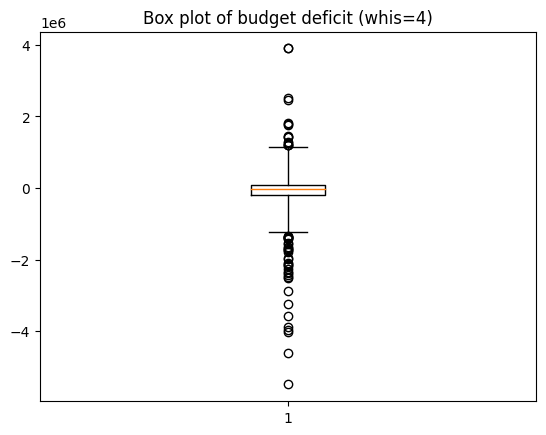

In [50]:
plt.boxplot(budget_deficit, whis = 4)
plt.title("Box plot of budget deficit (whis=4)")
plt.show()

Our box plot shows that we have outliers on both tails. Therefore, we will apply two-way winsorization to set limits on both the lowest end and the highest end of the distribution.

In [51]:
winsorized_budget = winsorize(budget_deficit, (0.10, 0.10))

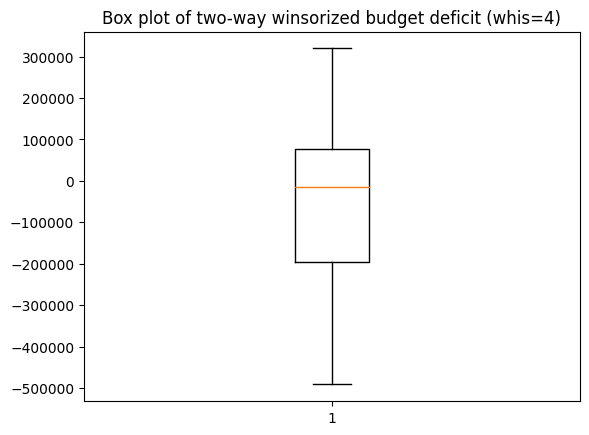

In [52]:
plt.boxplot(winsorized_budget, whis = 4)
plt.title("Box plot of two-way winsorized budget deficit (whis=4)")
plt.show()

As before, winsorization removes the outliers.

#### Q4. Now create another variable by subtracting `TOTAL_EXPENDITURE` from `TOTAL_REVENUE`. This time, use the outlier eliminated versions of `TOTAL_EXPENDITURE` from `TOTAL_REVENUE`. In this newly created variable, can you find any outliers? If so, eliminate them.

The outlier eliminated versions is the ones that we winsorized in question 2.

In [53]:
# New variable calculating winsorized_revenue  - winsorized_expenditure
budget_deficit_from_elim_vers = winsorized_revenue - winsorized_expenditure

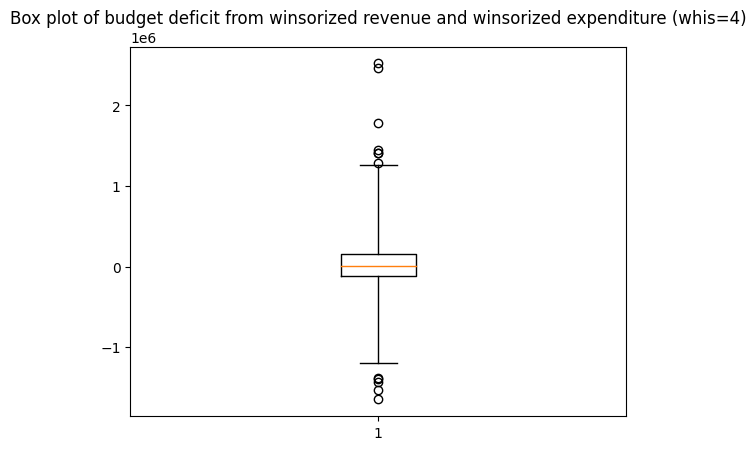

In [54]:
plt.boxplot(budget_deficit_from_elim_vers, whis = 4)
plt.title("Box plot of budget deficit from winsorized revenue and winsorized expenditure (whis=4)")
plt.show()

Surprisingly, we have outliers even though total revenue and total expenditures were both winsorized. We will eliminate them by two-way winsorization.

In [55]:
winsorized_budget_deficit_from_elim_vers = winsorize(budget_deficit_from_elim_vers, (0.10, 0.10))

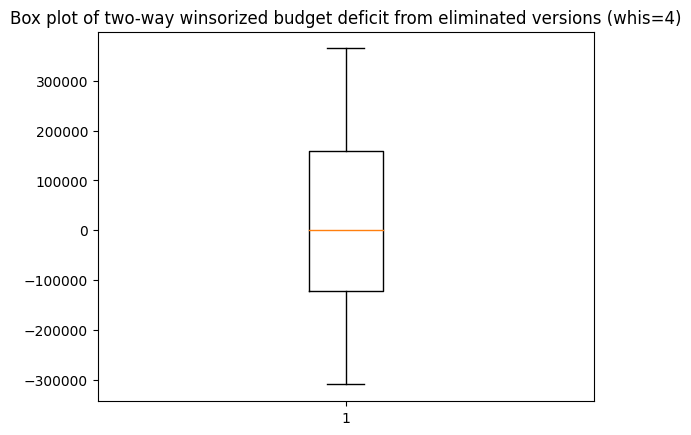

In [56]:
plt.boxplot(winsorized_budget_deficit_from_elim_vers, whis = 4)
plt.title("Box plot of two-way winsorized budget deficit from eliminated versions (whis=4)")
plt.show()

This successfully removes the outliers.

#### Q5. Compare some basic descriptive statistics of the budget variables you end up with in the third and the fourth questions. Do you see any differences?

`Series.describe` will show descriptive statistics about the multiple DataFrames.

In [57]:
# Generate descriptive statistics for our original budget, the winsorized budget,
# and the winsorized budget from eliminated versions of revenue and expenditure.
pd.DataFrame({'Original': budget_deficit,
              'Winsorized Budget': winsorized_budget,
              'Winsorized Budget (From Elim)': winsorized_budget_deficit_from_elim_vers
            }).describe()

,Original,Winsorized Budget,Winsorized Budget (From Elim)
count,1.046000e+03,1046.000000,1046.000000
mean,-8.971628e+04,-53699.987572,21680.043977
std,6.065230e+05,230989.969629,212637.250155
min,-5.487742e+06,-491440.000000,-309049.000000
25%,-1.949450e+05,-194945.000000,-120860.250000
50%,-1.583400e+04,-15834.000000,1668.000000
75%,7.736350e+04,77363.500000,159622.500000
max,3.897129e+06,319607.000000,364612.000000


These results show substantial differences between winsorizing the original budget deficit and winsorizing the deficit from the eliminated versions of revenue and expenditure. As an example:

- The mean of the winsorized deficit is $-53,699.98$ and the mean of winsorized deficit (from elimination) is $21,680.04$.

- The median of the first method is $-15,834$ whereas the median of the second method is $1,668$.

- The maximum of the first method is $319,607$ whereas the maximum of the second method is $36,4612$.

However, our analysis shows that in this example it is better to winsorize the base deficit from subtracting total expenditure from total revenue.


#### Q6. If your variable of interest is the budget deficit variable, which method do you think is the most appropriate in dealing with the outliers in this variable: the method in the third question or the one in the fourth question?

For this example it is better to subtract total expenditure from total revenue and then winsorize the resulting subtraction. It is **unclear** it this example is generalizable to other scenarios in which it would always be better to do the winsorization after subtracing variables.